In [1]:
import os
import pandas as pd

def filename(folder_path):
    file_names = []
    files_list = os.listdir(folder_path)
    for file_name in files_list:
        file_names.append(file_name)
    return file_names

directory_path = './data'  
audio_files = filename(directory_path)
def labeler(file_name):

    if len(file_name) >= 4:
        emotion = file_name[3]
    else:
        emotion = 'Unknown'  
    return file_name, emotion  


In [ ]:
data = [labeler(file_name) for file_name in audio_files]  
df = pd.DataFrame(data, columns=["address", "emotions"])  

In [3]:
from sklearn.model_selection import train_test_split

train_df, test_valid_df = train_test_split(df, test_size=0.2, stratify=df['emotions'],random_state=100)
validation_df, test_df = train_test_split(test_valid_df, test_size=0.5, stratify=test_valid_df['emotions'],random_state=100)

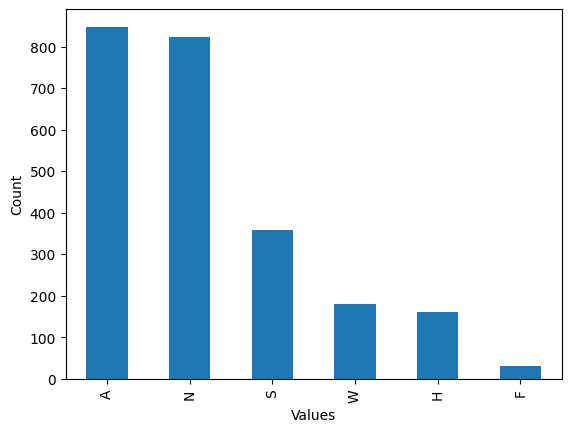

In [4]:
import matplotlib.pyplot as plt
train_df['emotions'].value_counts().plot(kind='bar')
plt.xlabel('Values')
plt.ylabel('Count')
plt.show()

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
len(list(df[df["emotions"] == "N"].values)) /  len(list(df[df["emotions"] == "S"].values)) 

2.289532293986637

In [7]:
(len(list(df[df["emotions"] == "N"].values)) -  len(list(df[df["emotions"] == "W"].values)) ) / len(list(df[df["emotions"] == "W"].values)) 

3.568888888888889

In [8]:
len(list(df[df["emotions"] == "N"].values)) /  len(list(df[df["emotions"] == "H"].values)) 

5.114427860696518

In [9]:
len(list(df[df["emotions"] == "N"].values)) /  len(list(df[df["emotions"] == "F"].values)) 

27.05263157894737

In [10]:
import librosa
import random
import torch
import random
import pandas as pd

def generate_simple_noise(waveform):
    return torch.rand_like(waveform)

def apply_random_transformation(audio_data, noise, sr=16000):
    augmented_audio =  noise + audio_data
    return augmented_audio

def augmentation(feature_name, df, target=1000):
    augmented_data = []
    count = 0
    file_names = list(df[df["emotions"] == feature_name]["address"])
    total = len(file_names)
    
    while count + total < target:
        rand = random.choice(file_names)
        file_path = "./data/" + rand
        waveform, _ = librosa.load(file_path, sr=16000)
        
        noise = generate_simple_noise(torch.from_numpy(waveform))
        
        augmented_audio = apply_random_transformation(waveform, noise.numpy(), 16000)

        augmented_data.append((augmented_audio, feature_name))
        count = count + 1

    augmented_df = pd.DataFrame(augmented_data, columns=["Input", "emotions"])
    return augmented_df



In [11]:
df.shape

(3000, 2)

In [12]:
AUDIOS_PATH = "./data/"

In [13]:
import librosa
class AudioDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.label_encoder = {"A":0,"N":1,"S":2,"W":3,"H":4,"F":5}

    def __len__(self):
        return self.df.shape[0]
   

    def __getitem__(self, index):
        filename = self.df.iloc[index]["address"]
        target = self.label_encoder[self.df.loc[index, "emotions"]]
        audio_path = os.path.join(AUDIOS_PATH, filename)
        waveform, _ = librosa.load(audio_path, sr=16000, mono=True)
        waveform_tensor = torch.from_numpy(waveform)

        return waveform_tensor.to(self.device), torch.tensor(target).to(self.device)


In [14]:
class AugmnetedDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.label_encoder = {"A":0,"N":1,"S":2,"W":3,"H":4,"F":5}
       
    def __len__(self):
        return self.df.shape[0]
   

    def __getitem__(self, index):
        waveform = self.df.iloc[index]["Input"]
        target = self.label_encoder[self.df.loc[index, "emotions"]]
        waveform_tensor = torch.from_numpy(waveform)
        return waveform_tensor.to(self.device), torch.tensor(target).to(self.device)

In [16]:
from transformers import HubertModel
from transformers import AutoTokenizer
from transformers import Wav2Vec2FeatureExtractor

fe = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-base-ls960")
model = HubertModel.from_pretrained("facebook/hubert-base-ls960")

Some weights of the model checkpoint at facebook/hubert-base-ls960 were not used when initializing HubertModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertModel were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for pre

In [17]:
import torch.nn as nn
class AudioModel(nn.Module):
    def __init__(self, model):
        super(AudioModel, self).__init__()
        self.model = model
        self.fc1 = nn.Linear(768, 6)

    def forward(self, x):
        x = self.model(x).last_hidden_state
        x = torch.mean(x, dim=1)
        x = self.fc1(x)

        return x

In [18]:
for param in model.feature_extractor.parameters():
    param.requires_grad = False

In [19]:
from torch import optim
from tqdm.auto import tqdm


In [20]:
H = augmentation("H",train_df,500)
F = augmentation("F",train_df,500)
S = augmentation("S",train_df,500)
W = augmentation("W",train_df,500)
augmentaion_df = pd.concat([H, F, S, W], ignore_index=True)

In [21]:
emotions_A_samples = train_df[train_df["emotions"] == "A"].sample(500)
emotions_N_samples = train_df[train_df["emotions"] == "N"].sample(500)
other_tags = train_df[~train_df["emotions"].isin(["A", "N"])]
filtered_train_df = pd.concat([emotions_A_samples, emotions_N_samples, other_tags])


In [22]:
from torch.utils.data import ConcatDataset
from torch.nn.utils.rnn import pad_sequence

def cfn(batch):
    a, l = zip(*batch)
    return pad_sequence([seq.squeeze(0) for seq in a], batch_first=True, padding_value=0), torch.stack(l)


filtered_train_df = filtered_train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)
augmentaion_df = augmentaion_df.reset_index(drop=True)


dataset = AudioDataset(filtered_train_df)
aug_dataset = AugmnetedDataset(augmentaion_df)
train_loader = DataLoader( ConcatDataset([dataset, aug_dataset]), batch_size=3, collate_fn=cfn,shuffle=True)
test_loader =  DataLoader( AudioDataset(test_df), batch_size=3, collate_fn=cfn,shuffle=True)
valid_loader = DataLoader( AudioDataset(validation_df), batch_size=3, collate_fn=cfn,shuffle=True)

In [23]:
import torch
torch.cuda.empty_cache()

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AudioModel(model).to(device)


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Epoch [1/5], Loss: 1.3480, Accuracy: 47.90%
Validation Epoch [1/5], Loss: 0.7191, Accuracy: 78.00%


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Epoch [2/5], Loss: 1.0564, Accuracy: 60.17%
Validation Epoch [2/5], Loss: 0.8263, Accuracy: 71.67%


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Epoch [3/5], Loss: 0.9556, Accuracy: 63.67%
Validation Epoch [3/5], Loss: 0.5643, Accuracy: 82.67%


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Epoch [4/5], Loss: 0.8850, Accuracy: 66.77%
Validation Epoch [4/5], Loss: 0.5289, Accuracy: 84.00%


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Epoch [5/5], Loss: 0.8181, Accuracy: 69.50%
Validation Epoch [5/5], Loss: 0.6239, Accuracy: 83.33%
Test F1 Score: 0.8514
Test Accuracy: 86.00%


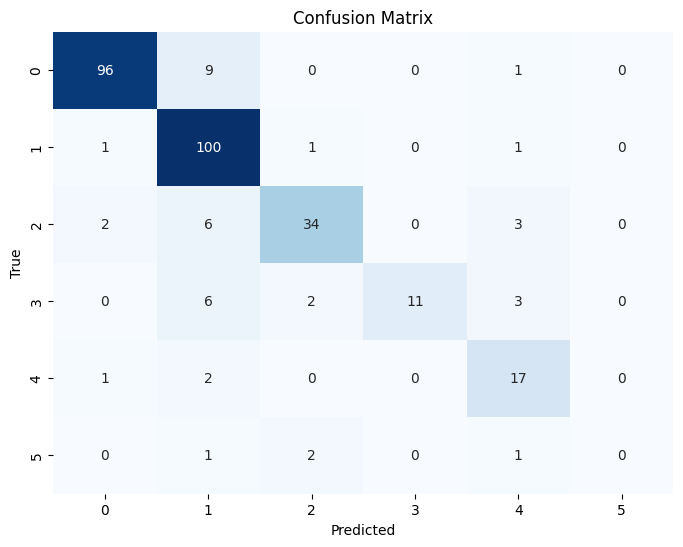

In [25]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

num_epochs = 5  

train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    for batch in tqdm(train_loader, position=0, leave=True):
        x, y = batch
        y = y.to(device)
        inputs = fe(x, return_tensors="pt", sampling_rate=16000).to(device)
        outputs = model(inputs.input_values.squeeze(0).squeeze(0))
        loss = criterion(outputs.float(), y.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == y).sum().item()
        total_predictions += y.size(0)
    
    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions * 100
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    
    print(f'Train Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch in valid_loader:
            x, y = batch
            y = y.to(device)
            inputs = fe(x, return_tensors="pt", sampling_rate=16000).to(device)
            outputs = model(inputs.input_values.squeeze(0).squeeze(0))
            loss = criterion(outputs.float(), y.long())
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == y).sum().item()
            total_predictions += y.size(0)

    epoch_loss = total_loss / len(valid_loader)
    epoch_accuracy = correct_predictions / total_predictions * 100
    
    valid_losses.append(epoch_loss)
    valid_accuracies.append(epoch_accuracy)
    
    print(f'Validation Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        true_labels.extend(y.cpu().numpy())
        y = y.to(device)
        inputs = fe(x, return_tensors="pt", sampling_rate=16000).to(device)
        outputs = model(inputs.input_values.squeeze(0).squeeze(0))
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())

f1 = f1_score(true_labels, predicted_labels, average='weighted')
test_accuracy = accuracy_score(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(f"Test F1 Score: {f1:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



Train F1 Score: 0.7126
Train Accuracy: 71.13%


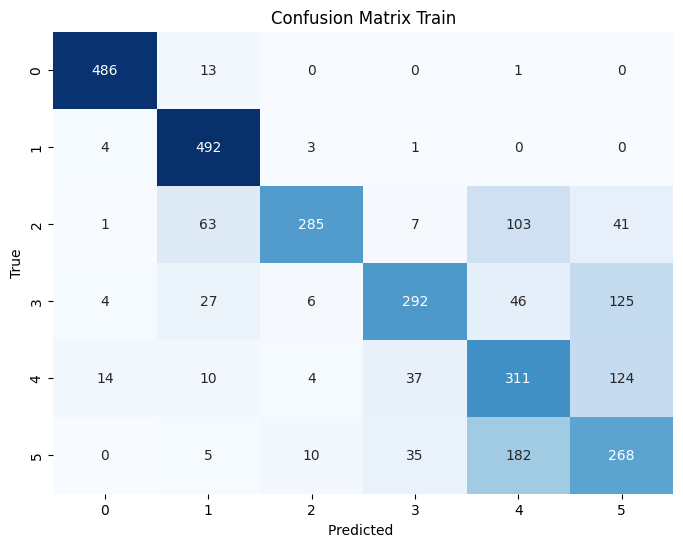

In [26]:
model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for batch in train_loader:
        x, y = batch
        true_labels.extend(y.cpu().numpy())
        y = y.to(device)
        inputs = fe(x, return_tensors="pt", sampling_rate=16000).to(device)
        outputs = model(inputs.input_values.squeeze(0).squeeze(0))
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())

f1 = f1_score(true_labels, predicted_labels, average='weighted')
test_accuracy = accuracy_score(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(f"Train F1 Score: {f1:.4f}")
print(f"Train Accuracy: {test_accuracy * 100:.2f}%")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted ')
plt.ylabel('True')
plt.title('Confusion Matrix Train')
plt.show()


In [27]:
epochs = range(1, num_epochs + 1)


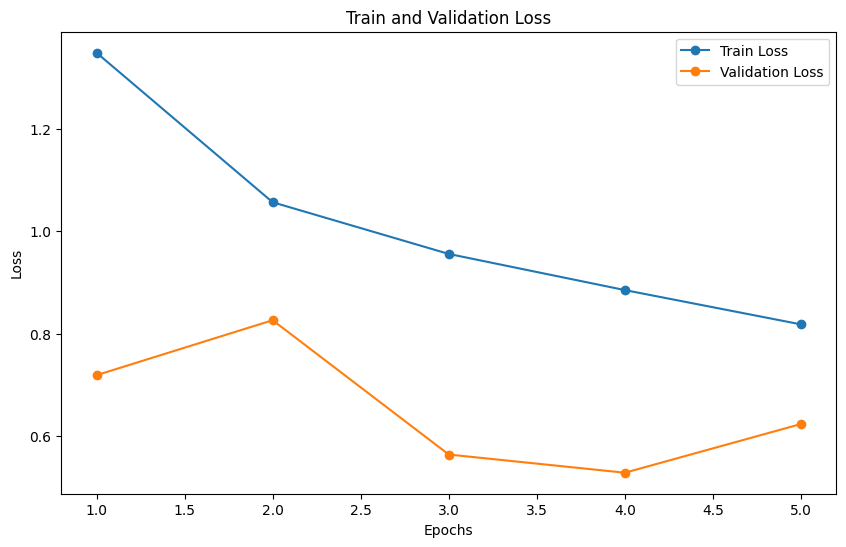

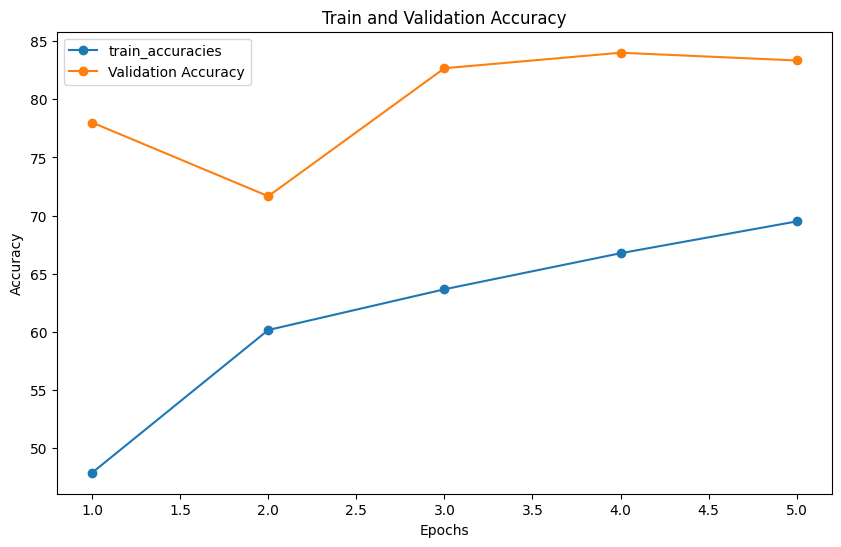

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss',marker='o', linestyle='-')
plt.plot(epochs, valid_losses, label='Validation Loss',marker='o', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='train_accuracies',marker='o', linestyle='-')
plt.plot(epochs, valid_accuracies, label='Validation Accuracy',marker='o', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()
